### Multi-label classificatio

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score

In [3]:
# no need this
# torch.cuda.set_device(0)
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

Tesla K80


In [4]:
PATH = 'data/'
arch=resnext50
bs=28

In [5]:
def get_data(size):
    tfms = tfms_from_model(arch, size, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)

In [6]:
size = 64
data = get_data(size)
data = data.resize(int(size*1.3), 'tmp') 
# for speed up training in different size by pre generate new size image

datasets: [<fastai.dataset.FilesIndexArrayDataset object at 0x7ff5bfd7c160>, <fastai.dataset.FilesIndexArrayDataset object at 0x7ff5bfd7c208>, <fastai.dataset.FilesIndexArrayDataset object at 0x7ff5bfd7c2b0>, <fastai.dataset.FilesIndexArrayDataset object at 0x7ff5bfd7c320>, None, None]


### 1. Find learning rate

 80%|████████  | 321/401 [00:14<00:03, 21.85it/s, loss=6.45]

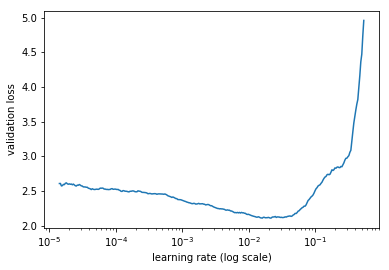

In [7]:
learn = ConvLearner.pretrained(arch, data)
learn.lr_find()
learn.sched.plot()

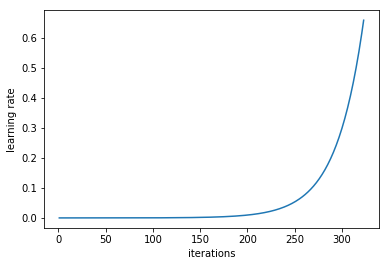

In [8]:
learn.sched.plot_lr()

### 2. Train Last Fully Connected Layer

In [9]:
lr = 0.03
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.709179   1.526657   0.406748  
    1      1.659959   1.507774   0.414315                   
    2      1.554606   1.471012   0.431697                   
    3      1.584538   1.496641   0.41227                    
    4      1.531028   1.447368   0.448466                   
    5      1.478557   1.43658    0.447444                   
    6      1.462171   1.433307   0.450102                   


[array([1.43331]), 0.45010224909565444]

### 3. Unfreeze to train all layers

In [10]:
learn.unfreeze()
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.441954   1.329301   0.484867  
    1      1.242419   1.124689   0.568916                   
    2      1.06877    0.990514   0.623108                   
    3      1.105127   1.00703    0.617791                   
    4      0.948175   0.961194   0.637014                    
    5      0.787578   0.821311   0.689366                    
    6      0.677301   0.804769   0.697955                    


[array([0.80477]), 0.6979550089877563]

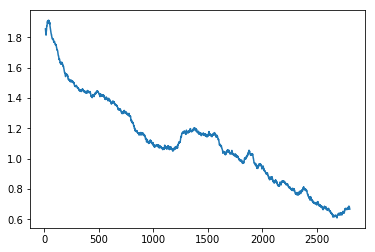

In [11]:
learn.save(f'{size}')
learn.sched.plot_loss()

In [12]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)
accuracy_np(preds,y)

0.7194274028629857

### 4. Change size to size=128 and do it again

In [13]:
size=128
learn.set_data(get_data(size))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

datasets: [<fastai.dataset.FilesIndexArrayDataset object at 0x7ff5be15eef0>, <fastai.dataset.FilesIndexArrayDataset object at 0x7ff55402de48>, <fastai.dataset.FilesIndexArrayDataset object at 0x7ff55402dd68>, <fastai.dataset.FilesIndexArrayDataset object at 0x7ff55402dcf8>, None, None]


epoch      trn_loss   val_loss   accuracy                   
    0      1.187951   1.130017   0.576074  
    1      1.1466     1.068657   0.602454                   
    2      1.117783   1.045491   0.608793                   
    3      1.152572   1.063606   0.598569                   
    4      1.119666   1.024457   0.613497                   
    5      1.056728   1.012595   0.622086                   
    6      1.051834   1.007644   0.62454                    


[array([1.00764]), 0.6245398778125553]

In [14]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{size}')

epoch      trn_loss   val_loss   accuracy                    
    0      0.740007   0.627557   0.775665  
    1      0.713519   0.611553   0.778528                    
    2      0.481751   0.474472   0.828425                    
    3      0.622737   0.651476   0.761759                    
    4      0.460179   0.506161   0.822086                    
    5      0.30778    0.377208   0.866667                    
    6      0.25831    0.361638   0.874847                    


### 5. Change size to size=256 and do it again

In [15]:
size=256
learn.set_data(get_data(size))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

datasets: [<fastai.dataset.FilesIndexArrayDataset object at 0x7ff5bc043048>, <fastai.dataset.FilesIndexArrayDataset object at 0x7ff5bc043198>, <fastai.dataset.FilesIndexArrayDataset object at 0x7ff5bc043160>, <fastai.dataset.FilesIndexArrayDataset object at 0x7ff5bc043208>, None, None]


epoch      trn_loss   val_loss   accuracy                    
    0      0.75123    0.685604   0.748466  
    1      0.729251   0.646027   0.769734                    
    2      0.713718   0.635821   0.773006                    
    3      0.750644   0.633698   0.768916                    
    4      0.72977    0.607353   0.783436                    
    5      0.678773   0.593763   0.78773                     
    6      0.669443   0.588215   0.789775                    


[array([0.58822]), 0.7897750523680315]

In [16]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{size}')

epoch      trn_loss   val_loss   accuracy                    
    0      0.427018   0.314735   0.887935  
    1      0.416038   0.300565   0.899387                    
    2      0.223462   0.220511   0.924744                    
    3      0.39236    0.370663   0.866053                    
    4      0.269093   0.260773   0.915951                    
    5      0.148151   0.193428   0.936401                    
    6      0.09368    0.183607   0.939877                     


### Last Accuracy

In [17]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)
accuracy_np(preds,y)

0.9427402862985685